In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
from math import ceil,sin,cos, atan2, pi, sqrt
import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions23 import *

In [2]:
path_bat = '/home/jvalenti/MOAD/grid/bathymetry_202108.nc'
bat = xr.open_dataset(path_bat,decode_times=False).Bathymetry

In [3]:
path_d='/results2/SalishSea/nowcast-green.202111/30oct22/SalishSea_1h_20221030_20221030_grid_T.nc'
path_d2='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_area='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_T.nc'
path_w='/results2/SalishSea/nowcast-green.202111/30oct22/SalishSea_1h_20221030_20221030_grid_W.nc'
path_w2='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_W.nc'
path_u='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_U.nc'
path_v='/results2/SalishSea/nowcast-green.202111/31oct22/SalishSea_1h_20221031_20221031_grid_V.nc'

path_mask = '/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TD.nc'
e3t = xr.open_dataset(path_d,decode_times=False).e3t
e3t2 = xr.open_dataset(path_d2,decode_times=False).e3t
e3t = xr.concat([e3t,e3t2],dim='time_counter')
Area = xr.open_dataset(path_area,decode_times=False).area
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy
zz_ww = xr.open_dataset(path_mask,decode_times=False).gdepw_0
e3t0 = xr.open_dataset(path_mask,decode_times=False).e3t_0

In [4]:
ssh = xr.open_dataset(path_d,decode_times=False).sossheig[:,445,302:307]
ssh2 = xr.open_dataset(path_d2,decode_times=False).sossheig[:,445,302:307]
ssh = xr.concat([ssh,ssh2],dim='time_counter')
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy[0,445,302:307]
u = xr.open_dataset(path_u,decode_times=False).vozocrtx[:,:,445,302:307]
w = xr.open_dataset(path_w,decode_times=False).vovecrtz[:,:,445,302:307]
w2 = xr.open_dataset(path_w2,decode_times=False).vovecrtz[:,:,445,302:307]
w = xr.concat([w,w2],dim='time_counter')
depthw = xr.open_dataset(path_w,decode_times=False).depthw
depthu = xr.open_dataset(path_u,decode_times=False).depthu
totaldepth = zz_ww[0, mbathy,445,302:307]

In [5]:
#Define domain
lon = np.array([250.,750., 1250.,1750.,2250.])
#lonu = np.array([500.,1000., 1500.,2000.,2500])
#latv = np.array([500.,1000.])
#lat = np.array([250.,750])
time = np.linspace(0,2*86400,48)

dim = 5
dep = len(depthu)
t = len(time)

#U = Field('U', u, dtype=np.float32)
#U = Field('U', u, lon=lonu, lat=None, depth=depthu, time=time)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, lat=None, depth=depthu)
W = Field('W', w, lon=lon, lat=None, depth=depthw, time=time)
SSH = Field('SSH', ssh, lon=lon, lat=None, depth=None, time=time)
Td = Field('TD', totaldepth, lon=lon, lat=None, depth=None, time=None)

In [6]:
fieldset = FieldSet(U,V)
fieldset.add_field(W)
fieldset.add_field(SSH)
fieldset.add_field(Td)

In [7]:
class MPParticle(JITParticle):
    fact = Variable('fact', initial =  1.0) 
class MPParticle2(JITParticle):
    fact = Variable('fact', initial =  0.0) 

In [8]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [9]:
w

<xarray.DataArray 'vovecrtz' (time_counter: 48, depthw: 40, x: 5)>
array([[[-9.28362454e-08, -9.65792779e-08, -1.00414539e-07,
         -1.03581598e-07, -1.06426462e-07],
        [-7.99219852e-05,  4.96365101e-05,  1.95369750e-04,
          1.32148649e-04,  2.49416742e-04],
        [-1.56511713e-04,  1.00840967e-04,  3.82982573e-04,
          2.69415672e-04,  4.90487204e-04],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00]],

       [[-1.33188189e-08, -1.47438985e-08, -1.55234581e-08,
         -1.68756014e-08, -1.79239308e-08],
        [ 1.16535062e-04, -4.52099675e-06,  2.51047095e-05,
         -5.94776830e-05, -8.52743938e-07],
        [ 2.31749946e-04, -1.15373450e-05,  5.13676860e-05,
         -1.16412273e-04,  3.89670868e-06],
...
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00]],

       [[ 1.09709530e-08,  1.09861595e-08,  1.08314637e-08,
          1.06662901e-08,  1.03537552e-08],
        [-1.97291345e-04, -7.90367703e-05, -1.48573890e-04,
         -6.57894198e-05,  1.27020990e-04],
        [-3.87905573e-04, -1.50112697e-04, -2.63472728e-04,
         -1.37418610e-04,  2.61419336e-04],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00]]], dtype=float32)
Coordinates:
    nav_lat        (x) float32 49.19 49.19 49.2 49.2 49.2
    nav_lon        (x) float32 -123.3 -123.3 -123.3 -123.3 -123.3
  * depthw         (depthw) float32 0.0 1.0 2.0 3.0 ... 347.2 374.1 401.1 428.0
    time_centered  (time_counter) float64 3.876e+09 3.876e+09 ... 3.876e+09
  * time_counter   (time_counter) float64 3.876e+09 3.876e+09 ... 3.876e+09
Dimensions without coordinates: x
Attributes:
    standard_name:       upward_sea_water_velocity
    long_name:           Ocean Vertical Velocity
    units:               m s-1
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)
    cell_measures:       area: area

In [10]:
def Advection(particle, fieldset, time):
    ssh = fieldset.SSH[time, particle.depth, particle.lat, particle.lon]
    td = fieldset.TD[time, particle.depth, particle.lat, particle.lon]
    if particle.fact == 1:
        factor = (1+ssh/td)
    else:
        factor=1
    (u1, v1, w1) = fieldset.UVW[time, particle.depth/factor, particle.lat, particle.lon]
    lon1 = particle.lon + u1*.5*particle.dt
    lat1 = particle.lat + v1*.5*particle.dt
    dep1 = particle.depth + w1*.5*particle.dt/factor
    (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1/factor, lat1, lon1]
    lon2 = particle.lon + u2*.5*particle.dt
    lat2 = particle.lat + v2*.5*particle.dt
    dep2 = particle.depth + w2*.5*particle.dt/factor
    (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2/factor, lat2, lon2]
    lon3 = particle.lon + u3*particle.dt
    lat3 = particle.lat + v3*particle.dt
    dep3 = particle.depth + w3*particle.dt/factor
    (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3/factor, lat3, lon3]
    particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
    particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
    particle.depth += (w1 + 2*w2 + 2*w3 + w4) / 6. * particle.dt/factor

In [11]:
n = 500
KE=Advection
lon_g = np.random.uniform(low=250, high=2000, size=(n,))
depth_g = np.random.uniform(low=0.5, high=30, size=(n,))
lat_g = np.ones(n,)*750
pset = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, depth=depth_g,lat = lat_g)
pset2 = ParticleSet(fieldset, pclass=MPParticle2, lon=lon_g, depth=depth_g,lat = lat_g)
output_file = pset.ParticleFile(name='Output.zarr', outputdt=3600)
output_file2 = pset2.ParticleFile(name='Output2.zarr', outputdt=3600)
pset.execute(KE , runtime=2*86400, dt=10, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
pset2.execute(KE , runtime=2*86400, dt=10, output_file=output_file2,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayMPParticleAdvection ==> /tmp/parcels-2894/lib12875f2f9e4ae8db04610fbed7eabd1c_0.so


Particle 171 lost !! [14160.0, 0.5057532787322998, 750.0, 1599.40234375]
Particle 52 lost !! [16040.0, 0.5040911436080933, 750.0, 1671.5562744140625]
Particle 186 lost !! [14780.0, 0.5034293532371521, 750.0, 1067.282958984375]
Particle 331 lost !! [15360.0, 0.5037201642990112, 750.0, 1359.2490234375]
Particle 155 lost !! [21320.0, 0.4985557198524475, 750.0, 279.15789794921875]
Particle 336 lost !! [19030.0, 0.5000892877578735, 750.0, 923.377197265625]
Particle 457 lost !! [21270.0, 0.49773815274238586, 750.0, 1592.7471923828125]
Particle 18 lost !! [24690.0, 0.4944502115249634, 750.0, 1220.930419921875]
Particle 69 lost !! [23800.0, 0.49551379680633545, 750.0, 1117.5308837890625]
Particle 258 lost !! [23750.0, 0.4939185678958893, 750.0, 1578.574951171875]
Particle 346 lost !! [25060.0, 0.49511921405792236, 750.0, 1022.7965087890625]
Particle 379 lost !! [22870.0, 0.4963148236274719, 750.0, 1343.77587890625]
Particle 467 lost !! [23070.0, 0.49717241525650024, 750.0, 877.0570678710938]
P

INFO: Output files are stored in Output.zarr.
 92%|█████████▏| 158400.0/172800.0 [00:03<00:00, 34433.65it/s] 

Particle 287 lost !! [168450.0, 0.5062151551246643, 750.0, 1295.9757080078125]


100%|██████████| 172800.0/172800.0 [00:04<00:00, 34898.42it/s]

Particle 382 lost !! [172470.0, 0.5046297311782837, 750.0, 1367.306884765625]



INFO: Compiled ArrayMPParticle2Advection ==> /tmp/parcels-2894/lib91b2b8c90d3e4e333ba43c4684583b99_0.so


Particle 671 lost !! [14200.0, 0.5002439022064209, 750.0, 1599.40234375]
Particle 552 lost !! [16000.0, 0.5000656843185425, 750.0, 1671.5562744140625]
Particle 686 lost !! [14820.0, 0.5000613331794739, 750.0, 1067.282958984375]
Particle 831 lost !! [15360.0, 0.5001914501190186, 750.0, 1359.2490234375]
Particle 655 lost !! [21240.0, 0.5000144839286804, 750.0, 279.15789794921875]
Particle 836 lost !! [18860.0, 0.5000028610229492, 750.0, 923.377197265625]
Particle 957 lost !! [21150.0, 0.500569224357605, 750.0, 1592.7471923828125]
Particle 518 lost !! [24640.0, 0.5007757544517517, 750.0, 1220.930419921875]
Particle 569 lost !! [23740.0, 0.5000123381614685, 750.0, 1117.5308837890625]
Particle 758 lost !! [23680.0, 0.5005307197570801, 750.0, 1578.574951171875]
Particle 846 lost !! [25020.0, 0.5004051327705383, 750.0, 1022.7965087890625]
Particle 879 lost !! [22790.0, 0.5003178715705872, 750.0, 1343.77587890625]
Particle 967 lost !! [23010.0, 0.5004687905311584, 750.0, 877.0570678710938]
Par

INFO: Output files are stored in Output2.zarr.
100%|██████████| 172800.0/172800.0 [00:05<00:00, 31097.31it/s] 

Particle 787 lost !! [171130.0, 0.5002261400222778, 750.0, 1295.9757080078125]


In [12]:
dat = xr.load_dataset('Output.zarr')
dat2 = xr.load_dataset('Output2.zarr')

/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [13]:
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy
def profdif(t):
    i = 445
    j = 304
    kmax = int(mbathy[0,i,j].item())
    dA = np.cumsum(e3t[t,:kmax,i,j])
    dC = np.cumsum(e3t0[0,:kmax,i,j])
    i = 445
    j = 305
    kmax = int(mbathy[0,i,j].item())
    dB = np.cumsum(e3t[t,:kmax,i,j])
    i = 445
    j = 303
    kmax = int(mbathy[0,i,j].item())
    dD = np.cumsum(e3t[t,:kmax,i,j])
    i = 445
    j = 302
    kmax = int(mbathy[0,i,j].item())
    dE = np.cumsum(e3t[t,:kmax,i,j])
    return dA,dB,dC,dD,dE
def ploting(axs,t):
    dA,dB,dC,dD,dE = profdif(t)
    for i in range(len(dA)):
        axs.axhline(y=-dA[i],xmin=0.5,xmax=0.75)
    for i in range(len(dB)):
        axs.axhline(y=-dB[i],xmin=0.75,xmax=1)
    #for i in range(len(dC)):
    #   axs.axhline(y=-dC[i],c='r',alpha = 0.2)
    for i in range(len(dD)):
       axs.axhline(y=-dD[i],xmin=0.25,xmax=0.5)
    for i in range(len(dE)):
       axs.axhline(y=-dE[i],xmin=0,xmax=0.25)
    
    #plt.fill_between(np.linspace(0,500,len(dA)), -np.ones(len(dA))*float(dA[-1]),-np.ones(len(dA))*float(dA[-1])-5, color='brown',zorder=5,alpha = 0.3) 
    #plt.fill_between(np.linspace(500,1000,len(dB)), -np.ones(len(dB))*float(dB[-1]),-np.ones(len(dB))*float(dB[-1])-15, color='brown',zorder=5,alpha = 0.3)  
    #plt.xlim([0,2000])
    plt.ylim([-28,0])

In [14]:
def anim2(file1,file2,fps=1):  
    #box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,1,figsize=(10,5))
    #axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
    #ax2 = axs[2].twiny()
    #ax2.plot(Kz_col,depth,c='r')
   
    #axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    #axs[1].plot(box[0],box[1],c='grey',linewidth=3)

    #axs[0].invert_yaxis()
    #axs[0].set_title('Initial condition (t: 0s)')
    axs.set_ylabel('Depth (m)')
    lent = np.linspace(0,48,len(file1.lon[0,:]))
    lent[-1]=lent[-2]
    def update(frame):              
        axs.clear()
        #axs[1].clear()
        axs.invert_yaxis()
        axs.set_title("Blue points z-stretch corrected")                 
        axs.scatter(file1.lon[:,frame],-file1.z[:,frame],s=5)
        #axs[1].invert_yaxis()
        #axs[1].set_title("Without e3t correction")                 
        axs.scatter(file2.lon[:,frame],-file2.z[:,frame],s=5)
        ploting(axs,round(lent[frame]))
        #ploting(axs[1],round(lent[frame]))
        axs.set_xlim([0,2000])
        axs.set_ylim([-30,0])       
        #axs[1].set_xlim([0,2000])
        #axs[1].set_ylim([-30,0])                 
        return 
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(file1.lon[0,:]),fps))

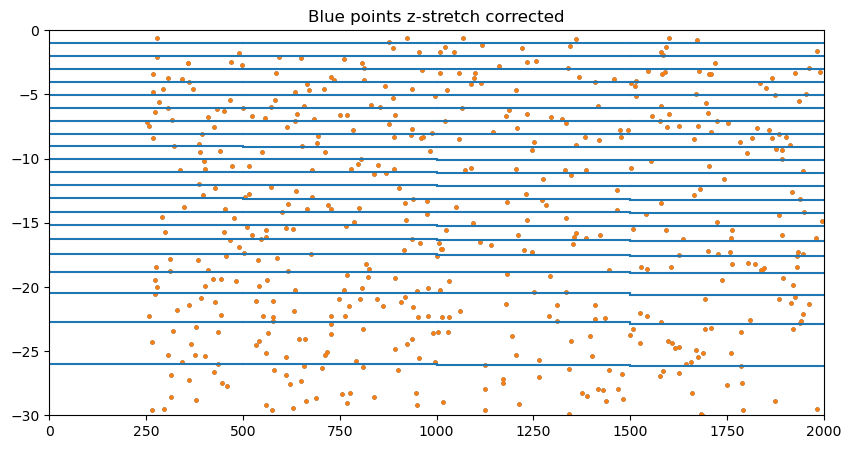

In [15]:
ss =[]
ani = anim2(dat,dat2,fps=1)
f = r"/home/jvalenti/MOAD/animations/box.gif" 
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

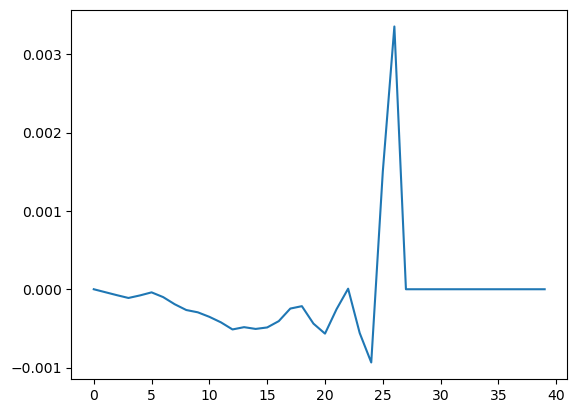

In [16]:
plt.plot(w[10,:,1])

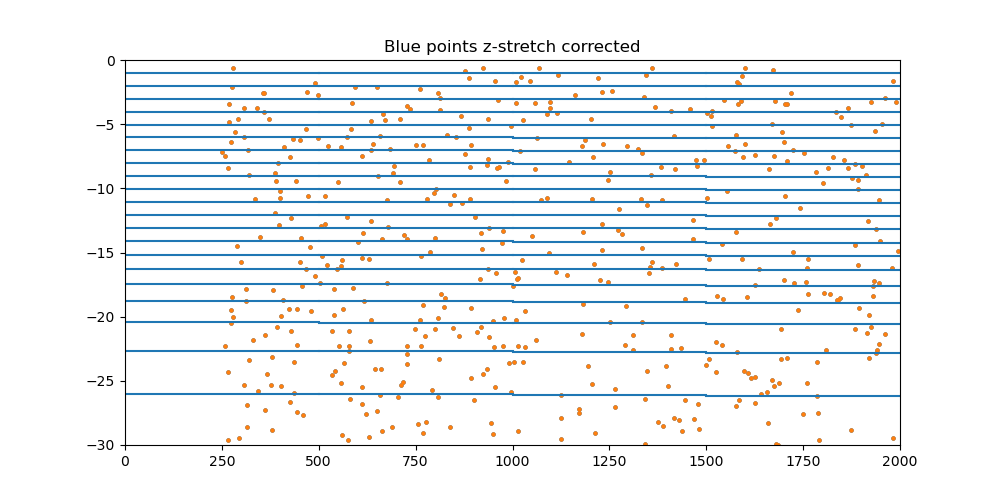

In [17]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))

In [18]:
# fig = plt.figure(figsize=(4,7))
# def update(frame):
#         fr = round(frame)
#         plt.clf()
#         ploting(fr)
# anim = animation.FuncAnimation(fig, update, frames=np.arange(0,23,1))
# f2 = r"/home/jvalenti/MOAD/animations/anim.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f2, writer = FFwriter)

In [19]:
# with open(f2,'rb') as anim:
#      display(Image(anim.read()))